## Build a Resnet model on Birds 

In [1]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization,Activation

In [2]:
train="D:\\ml\\PSC Project\\train"
test="D:\\ml\\PSC Project\\test"
valid="D:\\ml\\PSC Project\\valid"

In [3]:
len(os.listdir(train))

4

In [4]:
len(os.listdir(test))

4

In [5]:
len(os.listdir(valid))

4

In [6]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [7]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [8]:
df_train.head()

,filepaths,labels
0,D:\ml\PSC Project\train\ABBOTTS BABBLER\001.jpg,ABBOTTS BABBLER
1,D:\ml\PSC Project\train\ABBOTTS BABBLER\002.jpg,ABBOTTS BABBLER
2,D:\ml\PSC Project\train\ABBOTTS BABBLER\003.jpg,ABBOTTS BABBLER
3,D:\ml\PSC Project\train\ABBOTTS BABBLER\004.jpg,ABBOTTS BABBLER
4,D:\ml\PSC Project\train\ABBOTTS BABBLER\005.jpg,ABBOTTS BABBLER


Data Visualization

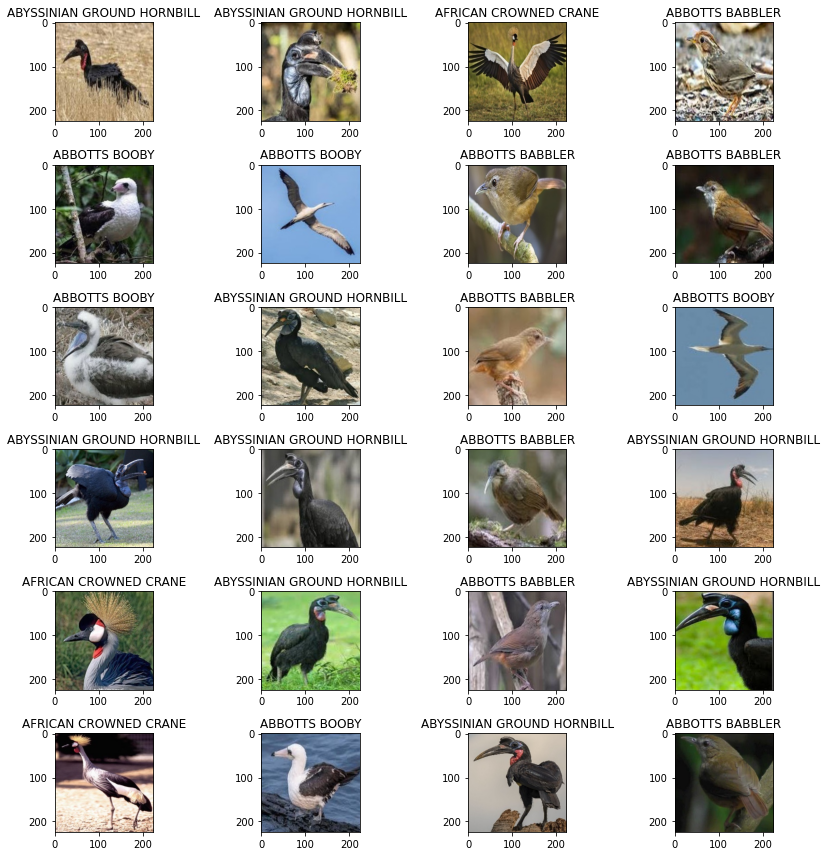

In [9]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()

Data Augmentation

In [10]:
train_generator=ImageDataGenerator(rescale=1/4)
test_generator=ImageDataGenerator(rescale=1/4)
valid_generator=ImageDataGenerator(rescale=1/4)

Reading the images from dataframe

In [11]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=256,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256
)


valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256
)

Found 662 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.


Model building

In [12]:
pretrained_model = ResNet101V2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False #We don't want to train again th resnet

In [13]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(4, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
mo_fit=model.fit(train_image,validation_data=valid_image,epochs=10)

Epoch 1/10
3/3 [==============================] - 67s 22s/step - loss: 7.8820 - accuracy: 0.2900 - val_loss: 11.1289 - val_accuracy: 0.2500
Epoch 2/10
3/3 [==============================] - 74s 24s/step - loss: 10.9657 - accuracy: 0.3338 - val_loss: 11.6077 - val_accuracy: 0.2000
Epoch 3/10
3/3 [==============================] - 76s 24s/step - loss: 9.6110 - accuracy: 0.3882 - val_loss: 6.8647 - val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 72s 22s/step - loss: 4.7745 - accuracy: 0.4109 - val_loss: 3.9740 - val_accuracy: 0.3500
Epoch 5/10
3/3 [==============================] - 71s 22s/step - loss: 3.2850 - accuracy: 0.3414 - val_loss: 3.8496 - val_accuracy: 0.2500
Epoch 6/10
3/3 [==============================] - 72s 28s/step - loss: 2.4914 - accuracy: 0.4215 - val_loss: 4.5166 - val_accuracy: 0.3000
Epoch 7/10
3/3 [==============================] - 73s 23s/step - loss: 2.6494 - accuracy: 0.4335 - val_loss: 2.8035 - val_accuracy: 0.4000
Epoch 8/10
3/3 [========

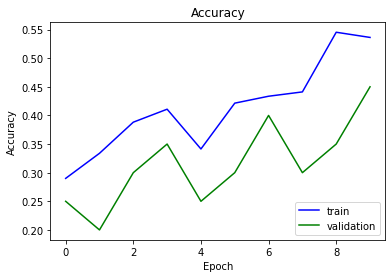

In [25]:
plt.plot(mo_fit.history['accuracy'],c='blue')
plt.plot(mo_fit.history['val_accuracy'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='lower right')

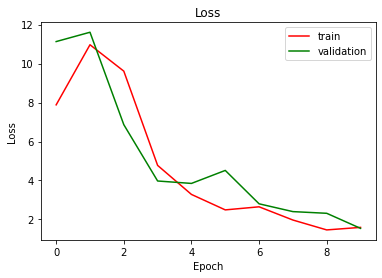

In [26]:
plt.plot(mo_fit.history['loss'],c='red')
plt.plot(mo_fit.history['val_loss'],c='green')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')

In [27]:
results = model.evaluate(train_image, verbose=0)

print("train Loss: {:.5f}".format(results[0]))
print("train Accuracy: {:.2f}%".format(results[1] * 100))

train Loss: 1.09393
train Accuracy: 60.27%


In [28]:
results = model.evaluate(valid_image, verbose=0)

print("valid Loss: {:.5f}".format(results[0]))
print("valid Accuracy: {:.2f}%".format(results[1] * 100))

valid Loss: 1.54374
valid Accuracy: 45.00%


In [29]:
results = model.evaluate(test_image, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 1.51095
Test Accuracy: 35.00%
